In [1]:
import json
import os

from cycler import cycler

import arviz as az
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl

from matplotlib import pyplot as plt
from pprint import pprint
from sphincter.data_preparation import load_prepared_data
from sphincter.plotting import plot_obs, plot_predictive, save_figure

INFERENCES_DIR = os.path.join("..", "inferences")
PLOTS_DIR = os.path.join("..", "plots")
CMAP = plt.get_cmap('Set2')

plt.rcParams['axes.prop_cycle'] = cycler(color=CMAP.colors)


In [2]:
prepared_data = load_prepared_data("../data/prepared/pressure.json")
msts = prepared_data.measurements
msts.head()

,mouse,age,treatment,map,pp,hr
0,11020,adult,ablation,48.490100,10.969394,5.112988
1,11020,adult,after_hyper1,50.055069,12.031981,5.178857
2,11020,adult,baseline,60.587775,12.960534,5.155377
3,11020,adult,hyper1,96.987509,13.702829,5.800671
4,11020,adult,hyper2,92.368492,8.044521,5.777388


In [3]:
idata = az.InferenceData.from_zarr(os.path.join(INFERENCES_DIR, "pressure", "idata"))

In [4]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"a_age[map, adult]",0.237,0.150,-0.031,0.524,0.003,0.002,3555.0,2916.0,1.0
"a_age[map, old]",-0.211,0.150,-0.493,0.062,0.003,0.002,3440.0,2874.0,1.0
"a_age[pp, adult]",0.050,0.157,-0.242,0.345,0.002,0.002,4119.0,2887.0,1.0
"a_age[pp, old]",-0.032,0.164,-0.339,0.271,0.003,0.002,3971.0,3249.0,1.0
"a_age[hr, adult]",-0.240,0.154,-0.545,0.027,0.003,0.002,3635.0,2947.0,1.0
...,...,...,...,...,...,...,...,...,...
"sigma_std[hr, 0]",0.703,0.100,0.532,0.903,0.001,0.001,6978.0,2606.0,1.0
"sigma_std[hr, 1]",1.122,0.146,0.881,1.416,0.002,0.001,6864.0,2512.0,1.0
"sigma_std[hr, 2]",0.588,0.070,0.467,0.727,0.001,0.001,5882.0,2794.0,1.0
"sigma_std[hr, 3]",0.510,0.065,0.392,0.631,0.001,0.001,7294.0,2523.0,1.0


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

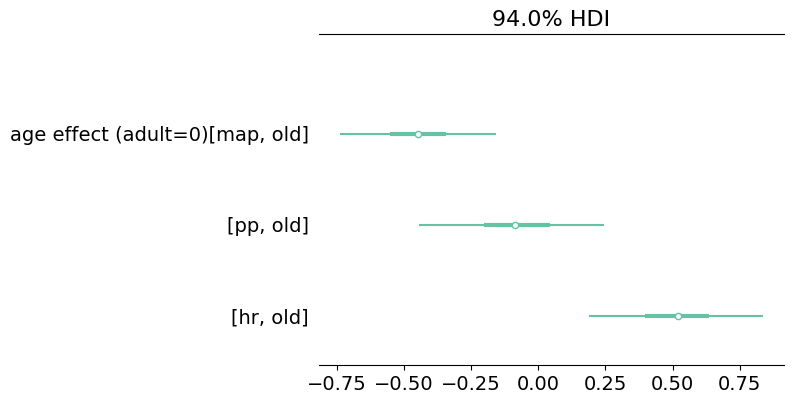

In [5]:
t = (
    idata.posterior["a_age"] - idata.posterior["a_age"].sel(age="adult")
).rename("age effect (adult=0)")


az.plot_forest(t, combined=True, coords={"age": ["old"]})

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

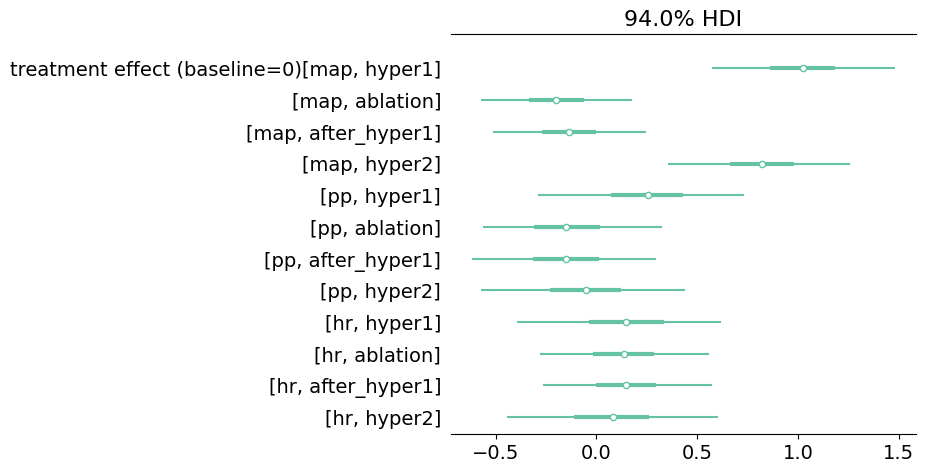

In [6]:
t = (
    idata.posterior["a_treatment"]
    - idata.posterior["a_treatment"].sel(treatment="baseline")
).rename("treatment effect (baseline=0)")

az.plot_forest(t, combined=True, coords={"treatment": ["hyper1", "ablation", "after_hyper1", "hyper2"]})

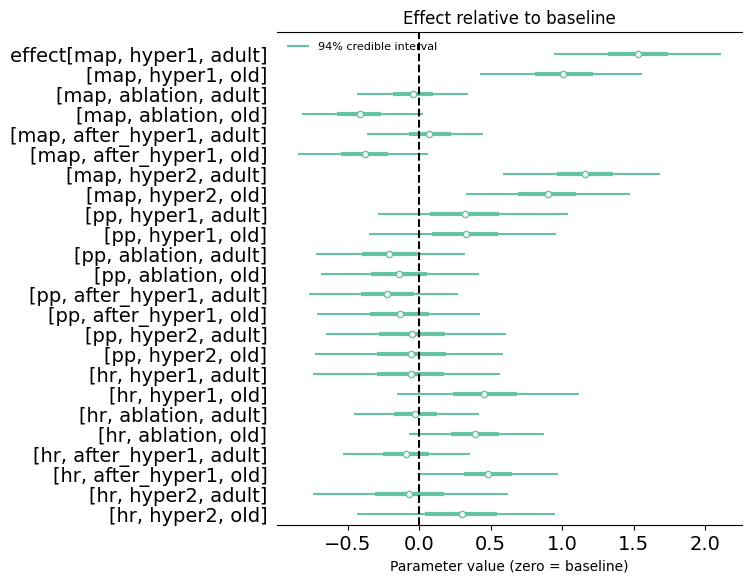

In [7]:
t = (
    idata.posterior["a_age"]
    + (idata.posterior["a_treatment"] - idata.posterior["a_treatment"].sel(treatment="baseline")) 
    + (idata.posterior["a_age_treatment"] - idata.posterior["a_age_treatment"].sel(treatment="baseline"))
).transpose(*["chain", "draw", "measurement_type", "treatment", "age"]).rename("effect")

az.plot_forest(
    t, 
    combined=True,
    coords={"treatment": ["hyper1", "ablation", "after_hyper1", "hyper2"]},
    legend=True
    
)
f = plt.gcf()
ax = plt.gca()
ax.axvline(0, linestyle="--", color="black")
ax.legend([ax.collections[0]], ["94% credible interval"], frameon=False, loc="upper left", fontsize=8)
ax.set(title="Effect relative to baseline", xlabel="Parameter value (zero = baseline)");

In [8]:
age_diff = t.sel(age="adult") - t.sel(age="old")
(age_diff.sel(measurement_type="hr", treatment="hyper2") > 0).to_numpy().mean()

0.187

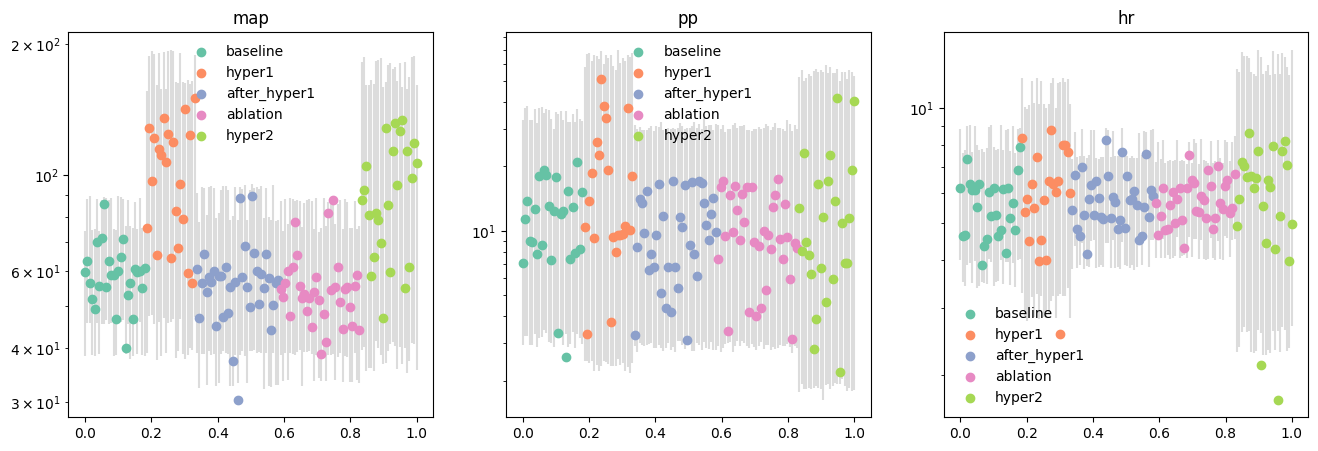

In [9]:
yrep = idata.posterior_predictive["yrep"]

f, axes = plt.subplots(1, 3, figsize=[16, 5])

for col, ax in zip(["map", "pp", "hr"], axes):
    plot_obs(ax, msts[col], cat=msts["treatment"]);
    plot_predictive(ax, yrep.sel(measurement_type=col), zorder=-1, cat=msts["treatment"])
    ax.legend(frameon=False)
    ax.set(title=col)
    ax.semilogy()

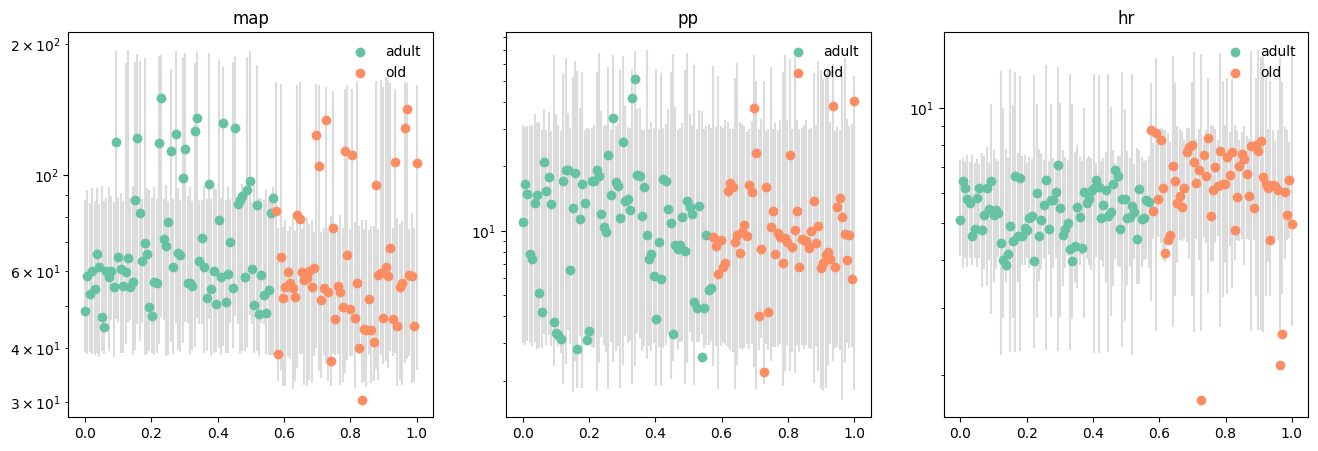

In [10]:
yrep = idata.posterior_predictive["yrep"]

f, axes = plt.subplots(1, 3, figsize=[16, 5])

for col, ax in zip(["map", "pp", "hr"], axes):
    plot_obs(ax, msts[col], cat=msts["age"]);
    plot_predictive(ax, yrep.sel(measurement_type=col), zorder=-1, cat=msts["age"])
    ax.legend(frameon=False)
    ax.set(title=col)
    ax.semilogy()